In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset, Dataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch.optim as optim
from sklearn.model_selection import ParameterGrid

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_seoul = pd.read_csv('/content/drive/MyDrive/train_seoul.csv', encoding='utf-8')
test_seoul = pd.read_csv('/content/drive/MyDrive/test_seoul.csv', encoding='utf-8')

In [4]:
from re import X
target_var = "관측미세먼지"

X_train = train_seoul.drop(columns=[target_var]).values
Y_train = train_seoul[target_var].values

X_test = test_seoul.drop(columns=[target_var]).values
Y_test = test_seoul[target_var].values

scaler = StandardScaler()

columns_to_scale_train = np.hstack((X_train[:, :-3], X_train[:, -1:]))
columns_to_scale_test = np.hstack((X_test[:, :-3], X_test[:, -1:]))
X_train_scaled = scaler.fit_transform(columns_to_scale_train)
X_test_scaled = scaler.transform(columns_to_scale_test)

X_train = np.hstack((X_train_scaled, X_train[:, -3:-2], X_train[:, -2:-1]))
X_test = np.hstack((X_test_scaled, X_test[:, -3:-2], X_test[:, -2:-1]))

train_columns = list(train_seoul.columns[:-4]) + [train_seoul.columns[-1], train_seoul.columns[-4], train_seoul.columns[-3]]

scaled_train_seoul = pd.DataFrame(X_train, columns=train_columns)
scaled_train_seoul[target_var] = Y_train
scaled_test_seoul = pd.DataFrame(X_test, columns=train_columns)
scaled_test_seoul[target_var] = Y_test

In [16]:
def create_sequences(data, sequence_length=32):
    sequences = []
    labels = []

    # "경과일"과 "경과시간"을 분 단위로 변환
    data['total_minutes'] = data['경과일'] * 1440 + data['경과시간']

    start_index = 0

    while start_index < len(data):
        start_time = data.iloc[start_index]['total_minutes']
        end_time = start_time + sequence_length

        end_index = start_index
        while end_index < len(data) and data.iloc[end_index]['total_minutes'] < end_time:
            end_index += 1

        subset = data.iloc[start_index:end_index]
        if len(subset) > 0:
            sequence = subset.drop(columns=['경과일', '경과시간', 'total_minutes', '관측미세먼지']).values

            # 시퀀스가 너무 길면 자르기
            if len(sequence) > sequence_length:
                sequence = sequence[:sequence_length]
            else:
                # 시퀀스 길이를 일정하게 만들기 위해 padding 적용
                padded_sequence = np.zeros((sequence_length, sequence.shape[1]))
                padded_sequence[:sequence.shape[0], :] = sequence
                sequence = padded_sequence

            sequences.append(sequence)
            # 라벨 생성: 마지막 "관측미세먼지" 값을 라벨로 사용
            label = 1 if subset[target_var].iloc[-1] > 80 else 0  # 라벨을 이진 분류 문제로 설정
            labels.append(label)

        start_index = end_index

    return np.array(sequences), np.array(labels)

In [17]:
# 시계열 데이터 생성
X_train_seq, y_train_seq = create_sequences(scaled_train_seoul)
X_test_seq, y_test_seq = create_sequences(scaled_test_seoul)

len(y_test_seq)

184

In [18]:
class TimeSeriesDataset(Dataset):
    def __init__(self, sequences, labels):
        self.sequences = sequences
        self.labels = labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return torch.tensor(self.sequences[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

train_dataset = TimeSeriesDataset(X_train_seq, y_train_seq)
test_dataset = TimeSeriesDataset(X_test_seq, y_test_seq)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [19]:
class TransformerEncoderModel(nn.Module):
    def __init__(self, input_dim, num_classes, nhead, num_encoder_layers, dim_feedforward, dropout):
        super(TransformerEncoderModel, self).__init__()
        encoder_layers = nn.TransformerEncoderLayer(d_model=input_dim, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_encoder_layers)
        self.fc = nn.Linear(input_dim, num_classes)

    def forward(self, src):
        src = src.permute(1, 0, 2)  # Transformer expects (seq_len, batch_size, input_dim)
        output = self.transformer_encoder(src)
        output = output.mean(dim=0)  # Average over the sequence length
        output = self.fc(output)
        return output

input_dim = 28  # input_dim을 28로 설정
num_classes = 2
nhead = 4
num_encoder_layers = 3
dim_feedforward = 128
dropout = 0.1

model = TransformerEncoderModel(input_dim, num_classes, nhead, num_encoder_layers, dim_feedforward, dropout)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 5
model.train()
for epoch in range(num_epochs):
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        output = model(X_batch)
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

torch.save(model.state_dict(), 'transformer_model.pth')

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/5, Loss: 0.02039450593292713
Epoch 2/5, Loss: 0.013311685994267464
Epoch 3/5, Loss: 0.00547271640971303
Epoch 4/5, Loss: 0.004312746226787567
Epoch 5/5, Loss: 0.005857654381543398


In [ ]:
# Grid search

# 하이퍼파라미터 그리드 설정
param_grid = {
    'sequence_length': [360],
    'num_encoder_layers': [2, 3],
    'dim_feedforward': [128, 256],
    'dropout': [0.1, 0.3],
    'lr': [1e-2, 1e-3]
}

# 그리드 서치를 위한 함수 정의
def grid_search(param_grid, train_data, test_data):
    best_accuracy = 0.0
    best_params = None
    best_cm = None

    for params in ParameterGrid(param_grid):
        print(f"Training with parameters: {params}")

        # 데이터 전처리
        sequence_length = params['sequence_length']
        X_train_seq, y_train_seq = create_sequences(train_data, sequence_length)
        X_test_seq, y_test_seq = create_sequences(test_data, sequence_length)

        train_loader = DataLoader(TimeSeriesDataset(X_train_seq, y_train_seq), batch_size=32, shuffle=True)
        test_loader = DataLoader(TimeSeriesDataset(X_test_seq, y_test_seq), batch_size=32, shuffle=False)

        # 모델 정의
        model = TransformerEncoderModel(input_dim=28, num_classes=2, nhead=4,
                                        num_encoder_layers=params['num_encoder_layers'],
                                        dim_feedforward=params['dim_feedforward'],
                                        dropout=params['dropout'])

        optimizer = optim.Adam(model.parameters(), lr=params['lr'])
        criterion = nn.CrossEntropyLoss()

        # Training loop
        num_epochs = 10  # 하이퍼파라미터 튜닝 시 시간 절약을 위해 epochs 수를 적게 설정
        model.train()
        for epoch in range(num_epochs):
            for X_batch, y_batch in train_loader:
                optimizer.zero_grad()
                output = model(X_batch)
                loss = criterion(output, y_batch)
                loss.backward()
                optimizer.step()

        # 예측 및 평가
        y_true, y_pred, test_accuracy = predict_and_evaluate(model, test_loader)

        # 혼동 행렬 출력
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["low", "high"])
        disp.plot(cmap=plt.cm.Blues, values_format='d')
        plt.title(f"Confusion Matrix\nParams: {params}")
        plt.show()

        # 최적 모델 저장
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_params = params
            best_cm = cm

    return best_params, best_accuracy, best_cm

# 하이퍼파라미터 그리드 서치 수행
best_params, best_accuracy, best_cm = grid_search(param_grid, scaled_train_seoul, scaled_test_seoul)

# 최적 하이퍼파라미터 및 정확도 출력
print(f'Best Params: {best_params}')
print(f'Best Accuracy: {best_accuracy:.2f}%')

# 최적 혼동 행렬 시각화
disp = ConfusionMatrixDisplay(confusion_matrix=best_cm, display_labels=["low", "high"])
disp.plot(cmap=plt.cm.Blues, values_format='d')

# 혼동 행렬의 제목에 최적 하이퍼파라미터 나열
plt.title(f"Confusion Matrix\nBest Params: {best_params}")
plt.show()


Test Accuracy: 92.93%


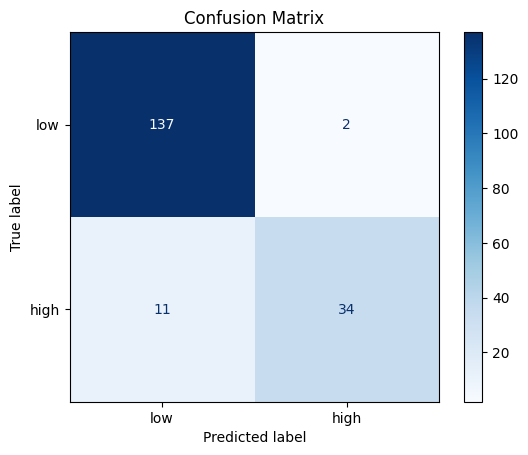

In [20]:
# Test loop
def predict_and_evaluate(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            output = model(X_batch)
            _, preds = torch.max(output.data, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())
            total += y_batch.size(0)
            correct += (preds == y_batch).sum().item()

    accuracy = 100 * correct / total
    return all_labels, all_preds, accuracy

# 모델 로드
model = TransformerEncoderModel(input_dim=28, num_classes=2, nhead=nhead, num_encoder_layers=num_encoder_layers,
                                dim_feedforward=dim_feedforward, dropout=dropout)
model.load_state_dict(torch.load('transformer_model.pth'))

# 테스트 데이터 로더 생성
test_loader = DataLoader(TimeSeriesDataset(X_test_seq, y_test_seq), batch_size=32, shuffle=False)

# 예측 및 평가
y_true, y_pred, test_accuracy = predict_and_evaluate(model, test_loader)

print(f'Test Accuracy: {test_accuracy:.2f}%')

# Confusion Matrix 계산
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["low", "high"])

# Confusion Matrix 시각화
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
def preprocess_input(date, time, scaled_data, sequence_length=1440):
    # 날짜와 시간을 분 단위로 변환
    total_minutes = date * 1440 + time

    # 입력 시퀀스 생성
    subset = scaled_data[scaled_data['total_minutes'] <= total_minutes].tail(sequence_length)

    # 확인: subset의 길이 확인
    print(f"Subset length: {len(subset)}")

    if len(subset) < sequence_length:
        padded_sequence = np.zeros((sequence_length, len(subset.columns) - 4))
        if len(subset) > 0:
            sequence = subset.drop(columns=['경과일', '경과시간', 'total_minutes', '관측미세먼지']).values
            padded_sequence[-len(sequence):, :] = sequence
    else:
        sequence = subset.drop(columns=['경과일', '경과시간', 'total_minutes', '관측미세먼지']).values
        padded_sequence = sequence[-sequence_length:]

    return torch.tensor(padded_sequence, dtype=torch.float32).unsqueeze(0)

In [ ]:
def classify_air_quality(date, time, scaled_data):
    # 모델 로드
    input_dim = 28
    num_classes = 2
    nhead = 4
    num_encoder_layers = 3
    dim_feedforward = 128
    dropout = 0.1

    model = TransformerEncoderModel(input_dim, num_classes, nhead, num_encoder_layers, dim_feedforward, dropout)
    model.load_state_dict(torch.load('transformer_model.pth'))
    model.eval()

    # 입력 데이터 전처리
    input_tensor = preprocess_input(date, time, scaled_data)

    # 예측
    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output.data, 1)

    # 결과 출력
    if predicted.item() == 1:
        return "고미세먼지"
    else:
        return "아님"

In [ ]:
# 사용 예시
date = 2000  # 예시 날짜 (경과일)
time = 720  # 예시 시간 (경과시간)
result = classify_air_quality(date, time, scaled_train_seoul)
print(f'날짜: {date}, 시간: {time} - 미세먼지 농도: {result}')